In [2]:
import requests
import json
import time
from functools import cache

from dataclasses import dataclass 
from enum import Enum, StrEnum, Flag, auto

In [3]:
@cache
def get_data(url) -> dict:
    """Avoid hitting endpoint for same data repeatedly"""
    referrer = "https://wyldata.com/iframes/wsk-owsr1-ranking"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:129.0) Gecko/20100101 Firefox/129.0",
        "Accept": "*/*",
        "Accept-Language": "en-US,en;q=0.5",
        "Sec-GPC": "1",
        "Sec-Fetch-Dest": "empty",
        "Sec-Fetch-Mode": "cors",
        "Sec-Fetch-Site": "same-origin",
        "Priority": "u=4",
        "Pragma": "no-cache",
        "Cache-Control": "no-cache",
        "referer": referrer
    }

    response = requests.get(url, headers=headers, allow_redirects=False)
    response.raise_for_status()
    data = json.loads(response.text)
    return data

def get_pages(starting_url, max_pages=5, pause_seconds=1):
    count = 0
    next_url = starting_url
    results = []
    while count < max_pages and next_url is not None:
        print("Fetching page", next_url)
        data = get_data(next_url)
        results.extend(data["results"])
        next_url = data.get('next')
        count +=1
        time.sleep(pause_seconds)
    
    return results

class Stance(StrEnum):
    REGULAR = auto()
    GOOFY = auto()

class Style(Flag):
    STREET = auto()
    PARK = auto()    

class Gender(StrEnum):
    MALE = auto()
    FEMALE = auto()

@dataclass
class Skater:
    id: int
    name: str
    age: int
    stance: Stance
    style: Style
    country: str
    gender: str


def make_skater(data: dict, style_fetched: Style):
    return Skater(
        data["id"],
        data["first_name"] + " " + data["last_name"],
        data["age"],
        Stance.REGULAR if data["stance"] == 1 else Stance.GOOFY,
        style_fetched,
        data["country"]["name"],
        Gender.MALE if data["gender"] == 1 else Gender.FEMALE
    )

def make_url(style: Style, gender: Gender):
    gender_num = 0 if gender == Gender.FEMALE else 1
    style_num = 1 if style == Style.PARK else 2
    url = f"https://wyldata.com/api/iframes/ranking/olympic-paris/?gender={gender_num}&discipline={style_num}&nation&continent&type=WITH_NC"
    return url

def make_skater_dict(s: Skater):
    return {
        "id": s.id,
        "name": s.name,
        "age": s.age,
        "stance": str(s.stance),
        "style": str(s.style),
        "country": s.country,
        "gender": str(s.gender)
    }

def skater_from_dict(s: dict):
    return Skater(
        s["id"],
        s["name"],
        s["age"],
        Stance.REGULAR if s["stance"] == str(Stance.REGULAR) else Stance.GOOFY,
        Style.PARK if s["style"] == str(Style.PARK) else Style.STREET,
        s["country"],
        Gender.FEMALE if s["gender"] == str(Gender.FEMALE) else Gender.MALE
    )


''' Disabling this code to avoid refetching data. Use the saved JSON file
skaters: list[Skater] = []

for style in [Style.PARK, Style.STREET]:
    for gender in [Gender.MALE, Gender.FEMALE]:
        url = make_url(style, gender)
        data = get_pages(url)
        skaters.extend(make_skater(s, style) for s in data)

with open("skateboarding-data/skaters.json", "w") as f:
    json.dump([make_skater_dict(s) for s in skaters], f, indent=4)
'''


with open("skateboarding-data/skaters.json") as f:
    skaters = [skater_from_dict(s) for s in json.load(f)]


In [4]:
skaters[0]

Skater(id=4233, name='Gavin Bottger', age=17, stance=<Stance.GOOFY: 'goofy'>, style=<Style.PARK: 2>, country='United States of America', gender=<Gender.MALE: 'male'>)

In [5]:
# Find skaters in both styles and merge them
skaters_by_id: dict[int, Skater] = {}
for s in skaters:
    if s.id in skaters_by_id:
        print("Rides both events: ", s)
        skaters_by_id[s.id].style |= s.style
    else:
        skaters_by_id[s.id] = s

# Only 12 out of ~600 skaters compete in both events
original_n = len(skaters)
skaters = skaters_by_id.values()
print(f"Merged {original_n - len(skaters)} items.")

Rides both events:  Skater(id=2905, name='Jagger Eaton', age=23, stance=<Stance.REGULAR: 'regular'>, style=<Style.STREET: 1>, country='United States of America', gender=<Gender.MALE: 'male'>)
Rides both events:  Skater(id=3048, name='Hampus Winberg', age=18, stance=<Stance.REGULAR: 'regular'>, style=<Style.STREET: 1>, country='Sweden', gender=<Gender.MALE: 'male'>)
Rides both events:  Skater(id=38796, name='Jett De Haan', age=17, stance=<Stance.REGULAR: 'regular'>, style=<Style.STREET: 1>, country='New Zealand', gender=<Gender.MALE: 'male'>)
Rides both events:  Skater(id=4327, name='Simon Karlsson', age=28, stance=<Stance.REGULAR: 'regular'>, style=<Style.STREET: 1>, country='Sweden', gender=<Gender.MALE: 'male'>)
Rides both events:  Skater(id=39181, name='Carl Öjert', age=17, stance=<Stance.REGULAR: 'regular'>, style=<Style.STREET: 1>, country='Sweden', gender=<Gender.MALE: 'male'>)
Rides both events:  Skater(id=4341, name='Daniela Terol', age=15, stance=<Stance.REGULAR: 'regular'>, s

In [6]:
# Overall numbers
def calculate_distro(skaters: list[Skater]):
    goofy_count = len([s for s in skaters if s.stance == Stance.GOOFY])
    regular_count = len([s for s in skaters if s.stance == Stance.REGULAR])
    n = len(skaters)

    print(f"Out of {n} skaters \n{regular_count} ride regular ({100*regular_count/n:.0f}%) and \n{goofy_count} ride goofy ({100*goofy_count/n:.0f}%)")

calculate_distro(skaters)

Out of 620 skaters 
291 ride regular (47%) and 
329 ride goofy (53%)


In [7]:
# By Event style:

print("For Park events")
calculate_distro([s for s in skaters if (s.style & Style.PARK)])
print("-----------------------\n")

print("For Street events")
calculate_distro([s for s in skaters if (s.style & Style.STREET)])

For Park events
Out of 281 skaters 
143 ride regular (51%) and 
138 ride goofy (49%)
-----------------------

For Street events
Out of 350 skaters 
157 ride regular (45%) and 
193 ride goofy (55%)


In [8]:
# By age
aged = [s for s in skaters if s.age is not None]
print(f"{len(skaters) - len(aged)} skaters missing age")
print("\n")

print("Skaters older than 25")
calculate_distro([s for s in aged if s.age >= 25])
print("-----------------------\n")

print("Skaters 18-25")
calculate_distro([s for s in aged if s.age >= 18 and s.age < 25])
print("-----------------------\n")

print("Skaters younger than 18")
calculate_distro([s for s in aged if s.age < 18])


21 skaters missing age


Skaters older than 25
Out of 168 skaters 
67 ride regular (40%) and 
101 ride goofy (60%)
-----------------------

Skaters 18-25
Out of 228 skaters 
111 ride regular (49%) and 
117 ride goofy (51%)
-----------------------

Skaters younger than 18
Out of 203 skaters 
100 ride regular (49%) and 
103 ride goofy (51%)


In [9]:
# By Country
from collections import Counter

country_count = Counter([s.country for s in skaters])
most_common_countries = country_count.most_common(5)
print(most_common_countries)

for country, count in most_common_countries:
    print(f"Skaters in {country}")
    calculate_distro([s for s in skaters if s.country == country])
    print("-----------------------\n")

print(f"Skaters everywhere else")
common_country_names = [c[0] for c in most_common_countries]
calculate_distro([s for s in skaters if s.country not in common_country_names])

[('United States of America', 50), ('Brazil', 48), ('Japan', 45), ('Australia', 33), ('Mexico', 26)]
Skaters in United States of America
Out of 50 skaters 
25 ride regular (50%) and 
25 ride goofy (50%)
-----------------------

Skaters in Brazil
Out of 48 skaters 
23 ride regular (48%) and 
25 ride goofy (52%)
-----------------------

Skaters in Japan
Out of 45 skaters 
29 ride regular (64%) and 
16 ride goofy (36%)
-----------------------

Skaters in Australia
Out of 33 skaters 
23 ride regular (70%) and 
10 ride goofy (30%)
-----------------------

Skaters in Mexico
Out of 26 skaters 
11 ride regular (42%) and 
15 ride goofy (58%)
-----------------------

Skaters everywhere else
Out of 418 skaters 
180 ride regular (43%) and 
238 ride goofy (57%)


In [10]:
# By gender
for gender in [Gender.FEMALE, Gender.MALE]:
    print(f"{gender} Skaters")
    calculate_distro([s for s in skaters if s.gender == gender])
    print("-----------------------\n")

female Skaters
Out of 217 skaters 
109 ride regular (50%) and 
108 ride goofy (50%)
-----------------------

male Skaters
Out of 403 skaters 
182 ride regular (45%) and 
221 ride goofy (55%)
-----------------------



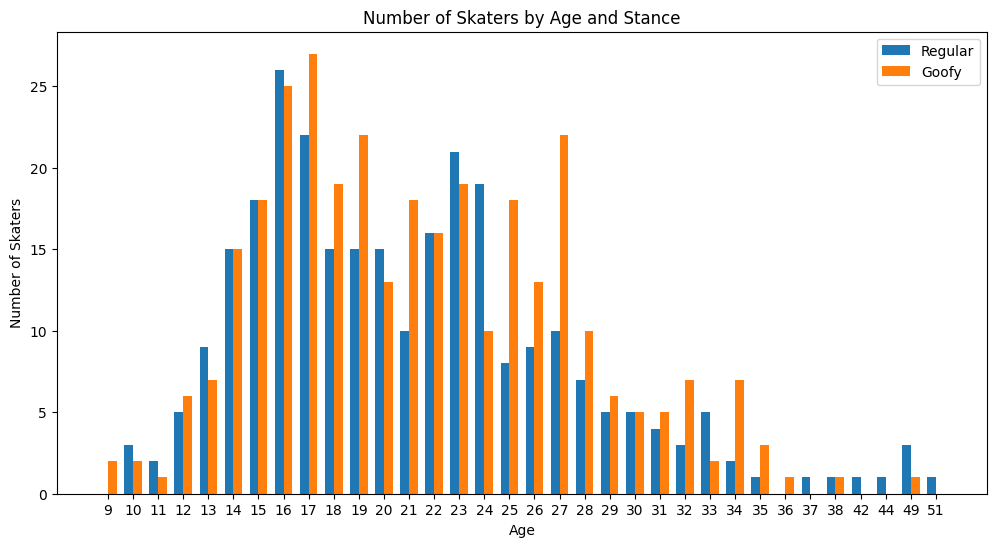

In [14]:
import matplotlib.pyplot as plt
import numpy as np

regular_ages = [skater.age for skater in skaters if skater.stance == Stance.REGULAR and skater.age]
goofy_ages = [skater.age for skater in skaters if skater.stance == Stance.GOOFY and skater.age]

# Get unique ages
unique_ages = sorted(set(regular_ages + goofy_ages))

# Count skaters per age
regular_count = Counter(regular_ages)
goofy_count = Counter(goofy_ages)

# Prepare data for the plot
regular_values = [regular_count.get(age, 0) for age in unique_ages]
goofy_values = [goofy_count.get(age, 0) for age in unique_ages]

# Plot the data
x = np.arange(len(unique_ages))  # X-axis positions
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width/2, regular_values, width, label='Regular')
ax.bar(x + width/2, goofy_values, width, label='Goofy')

# Labels and legend
ax.set_xlabel('Age')
ax.set_ylabel('Number of Skaters')
ax.set_title('Number of Skaters by Age and Stance')
ax.set_xticks(x)
ax.set_xticklabels(unique_ages)
ax.legend()

plt.show()

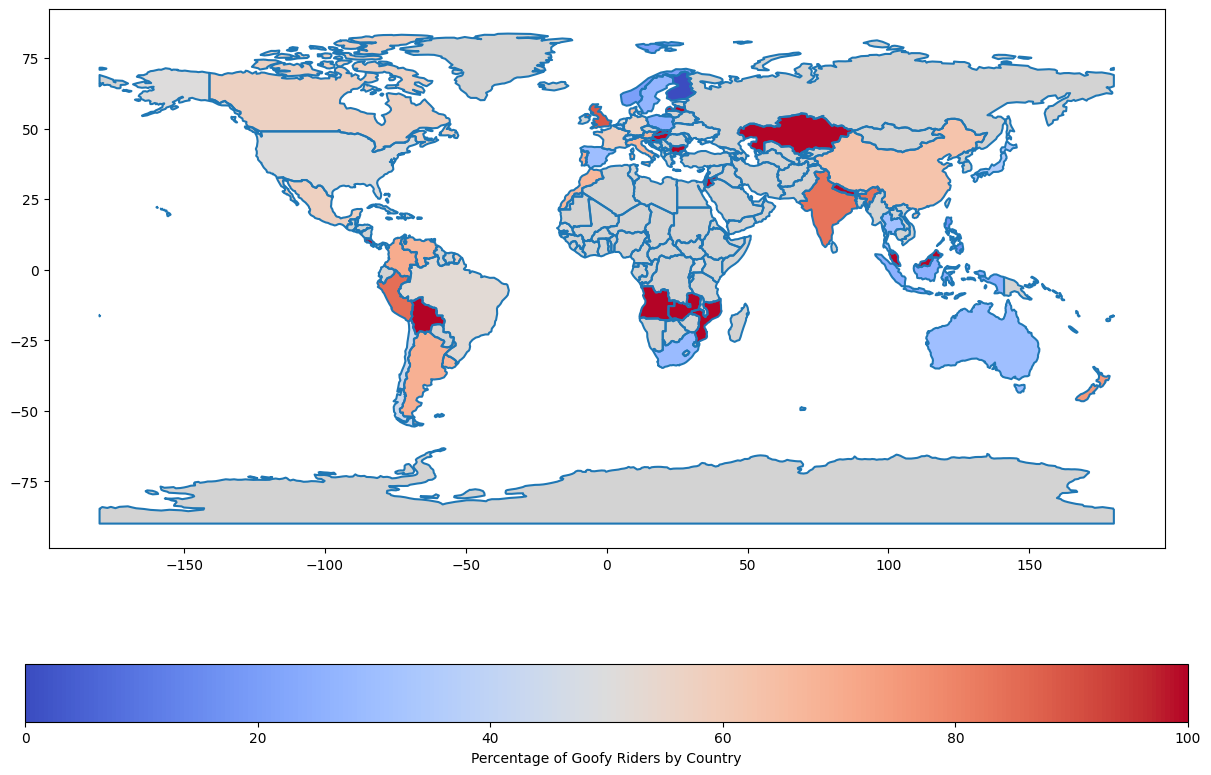

In [28]:
import geopandas as gpd
# Count skaters by country and stance
country_stance = {}
for skater in skaters:
    if skater.country not in country_stance:
        country_stance[skater.country] = {'Regular': 0, 'Goofy': 0}
    if skater.stance == Stance.REGULAR:
        country_stance[skater.country]['Regular'] += 1
    else:
        country_stance[skater.country]['Goofy'] += 1

# Calculate percentage of Goofy riders
percent_goofy = {}
for country, counts in country_stance.items():
    total = counts['Regular'] + counts['Goofy']
    percent_goofy[country] = (counts['Goofy'] / total) * 100 if total > 0 else 0

# Load world map using GeoPandas
world = gpd.read_file('skateboarding-data/countries/ne_110m_admin_0_countries.shp')

# Add percentage of Goofy riders to the GeoDataFrame
world['percent_goofy'] = world['ADMIN'].map(percent_goofy)

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax)
world.plot(column='percent_goofy', ax=ax, legend=True,
           legend_kwds={'label': "Percentage of Goofy Riders by Country",
                        'orientation': "horizontal"},
           cmap='coolwarm', missing_kwds={'color': 'lightgrey'})

# Display the map
plt.show()